In [54]:
#VADER = body_sentiment
#TextBlob = blob_sent

In [81]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pmaw import PushshiftAPI
import matplotlib.pyplot as plt
import math
from datetime import datetime
import datetime as dt
from nltk.tokenize import RegexpTokenizer, TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import re
import string
import seaborn as sns
from wordcloud import WordCloud

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
pd.set_option('display.max_colwidth', -1)

<ipython-input-81-4d7cd63834e5>:31: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [56]:
df = pd.read_csv('data/amc_modeling.csv', low_memory=False)

In [57]:
df.dropna(inplace=True)
df.isna().sum()

body                     0
score                    0
total_awards_received    0
created_utc              0
author                   0
permalink                0
cleaned_body             0
body_sentiment           0
blob_sent                0
dtype: int64

In [58]:
X = df['cleaned_body']
y = df['body_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [59]:
stopwords_list = stopwords.words('english')
vectorizer = CountVectorizer(stop_words=stopwords_list, max_features=200)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [60]:
# tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=200)
# X_train_vectorized = tfidf.fit_transform(X_train)
# X_test_vectorized = tfidf.transform(X_test)

In [61]:
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=vectorizer.get_feature_names())

10  100  20  30  50  actually  ago  already  also  always  ...  went  \
0      0   0    0   0   0   0         0    0        1     0       ...  0      
1      0   0    0   0   0   0         0    0        0     0       ...  0      
2      0   0    0   0   0   0         0    0        0     0       ...  0      
3      0   0    0   0   0   0         0    0        0     0       ...  0      
4      0   0    0   0   0   0         0    0        0     0       ...  0      
...   ..  ..   ..  ..  ..  ..        ..   ..       ..    ..       ... ..      
74908  0   0    0   0   0   0         0    0        0     0       ...  0      
74909  0   0    0   0   0   0         0    0        0     0       ...  0      
74910  0   0    0   0   0   0         0    0        0     0       ...  0      
74911  0   0    0   0   0   1         0    0        0     0       ...  0      
74912  0   0    0   0   0   0         0    0        0     0       ...  0      

       wish  worth  would  wsb  yeah  year  years  yes  youre  
0      0     0      0      0    0     0     0      0    0      
1      0     0      0      0    0     0     0      0    0      
2      0     0      0      0    0     0     0      0    0      
3      0     0      0      0    0     0     0      0    0      
4      0     0      0      0    0     0     0      0    0      
...   ..    ..     ..     ..   ..    ..    ..     ..   ..      
74908  0     0      0      0    0     0     0      0    0      
74909  0     0      0      0    0     0     0      0    0      
74910  0     0      0      0    0     0     0      0    0      
74911  0     0      0      0    0     0     0      0    0      
74912  0     0      0      0    0     0     0      0    0      

[74913 rows x 200 columns]

# Classification

### First Simple Model: NaiveBayes

In [62]:
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vectorized, y_train)
baseline_model.score(X_train_vectorized, y_train)

0.6643172747053249

In [63]:
y_pred_bm = baseline_model.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_bm))

0.6680682364247957


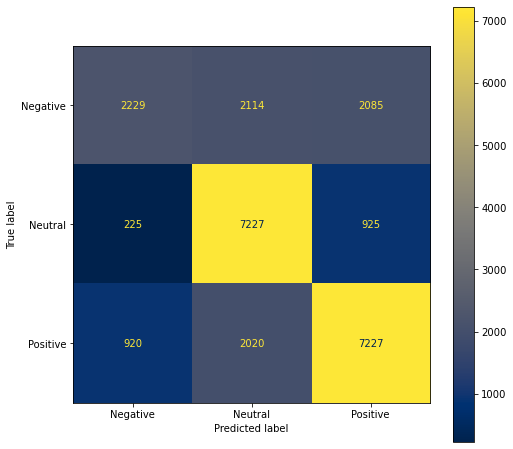

In [80]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(baseline_model, X_test_vectorized, y_test, ax=ax, cmap="cividis");

### RandomForest

In [64]:
rf = RandomForestClassifier()
rf.fit(X_train_vectorized, y_train)
rf.score(X_train_vectorized, y_train)

0.9038484642184934

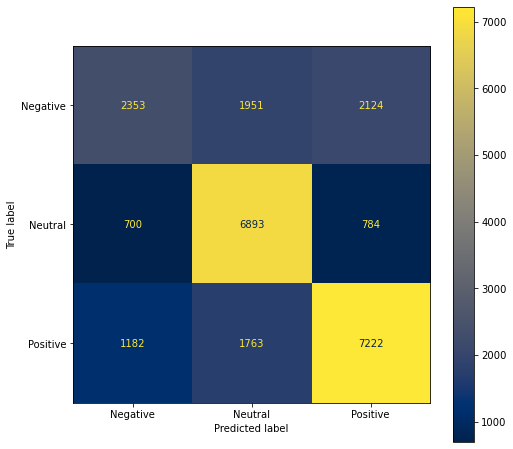

In [65]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(rf, X_test_vectorized, y_test, ax=ax, cmap="cividis");

In [66]:
y_pred_rf = rf.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_rf))

0.6594585936248598


### DecisionTree

In [67]:
dt = DecisionTreeClassifier()
dt.fit(X_train_vectorized, y_train)
dt.score(X_train_vectorized, y_train)

0.9038484642184934

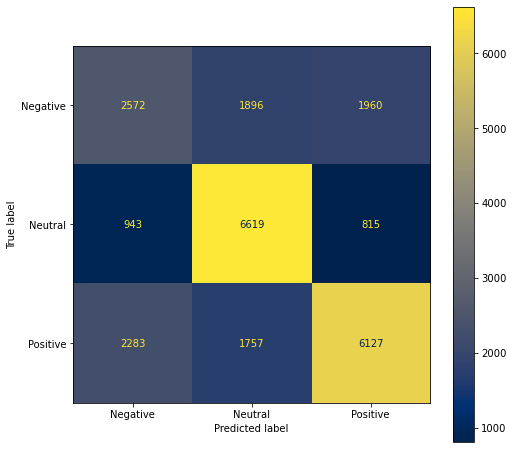

In [68]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(dt, X_test_vectorized, y_test, ax=ax, cmap="cividis");

In [69]:
y_pred_dt = dt.predict(X_test_vectorized)
y_pred_dt = dt.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_dt))

0.6134070158577607


### XGBoost

In [70]:
from xgboost import XGBClassifier

In [71]:
xgb = XGBClassifier(eval_metric='mlogloss')
xgb.fit(X_train_vectorized, y_train)
xgb.score(X_train_vectorized, y_train)

C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7187804519909762

In [72]:
y_pred_xgb = xgb.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_xgb))

0.6854076565753644


The XGBoost did the best with a .72 training score and .69 test score. The naive bayes was middle of the road. The training and test scores were similar at .66. The decision tree and random forest had massive overfitting resulting in much lower test scores than training scores. 

### Verifying the accuracy of the body_sentiment column by manual labeling

Create a random sample of 300 entries. Manually label the comments either positive, neutral, or negative. Verify the accuracy of body_sentiment generated by VADER. 
Create a new column generated by another lexicon sentiment analyzer, SentiWordNet (textblob). Next, test Flair (embedded model), and lastly a custom model. Verify the accuracy of the new column with the manually labeled column.

In [73]:
sample_df = df.sample(n=100, random_state=42)

In [74]:
# sample_df.iloc[90:100]['body']

In [75]:
labels = ['Positive','Positive','Negative','Negative','Positive','Negative','Positive','Positive','Neutral','Neutral',
         'Negative','Neutral','Positive','Positive','Neutral','Positive','Negative','Positive','Neutral','Positive',
          'Positive','Positive','Neutral','Positive','Neutral','Negative','Positive','Positive','Positive','Negative',
          'Negative','Positive','Positive','Neutral','Negative','Positive','Negative','Positive','Positive','Positive',
          'Positive','Positive','Positive','Neutral','Positive','Negative','Negative','Neutral','Neutral','Negative',
          'Neutral','Positive','Positive','Neutral','Positive','Positive','Neutral','Positive','Negative','Positive',
          'Negative','Neutral','Negative','Neutral','Positive','Negative','Positive','Neutral','Negative','Positive',
          'Negative','Negative','Positive','Positive','Neutral','Neutral','Positive','Positive','Negative','Neutral',
          'Positive','Negative','Positive','Neutral','Positive','Negative','Neutral','Neutral','Negative','Positive',
          'Positive','Neutral','Positive','Neutral','Positive','Positive','Positive','Positive','Neutral','Positive'
         ]

In [76]:
sample_df = sample_df[['body','cleaned_body','body_sentiment','blob_sent']]

In [77]:
sample_df['labels']=labels

In [78]:
accuracy_score(sample_df['labels'],sample_df['body_sentiment'])

0.43

In [79]:
accuracy_score(sample_df['labels'],sample_df['blob_sent'])

0.42

*SOOO it turns out that VADER is only returning a 43% accuracy score on it's rule based sentiment classifications as compared to my manually labeled column. When I performed the accuracy score on TextBlob sentiment classifications against the manually labeled column, it turned out to be very similar at 42% accuracy. It may be due to the subjective nature of posts in relation to the stock market and price, as well as the amount of noise present within reddit and social media environments in general.
<br><br>
Lets try quantitative analysis of the sentiment scores in the next section and how these scores changed over time. We will import the time series data we prepared in the EDA.*

# Time Series

In [84]:
ts = pd.read_csv('data/numeric_sents.csv', low_memory=False)
ts.head()

cleaned_body  \
0  same i love movies and some movies really have to be seen in the theater to really appreciate them when this is all over im definitely hitting up amc to watch some flicks with a beer and tendies   
1  i have a question for anyone that has the answer to this are the hedgefunds that shorted gme the same hedgefunds that shorted amc why are these two so similar in price action                       
2  hey guys on a scale of 110 how retarded am i i bought 7 puts on amc while it was tanking while 50 of everything ive earned is in it 9                                                                
3  got 50 amc at 1330 and 52 gme at 111 don’t forget me on the way                                                                                                                                      
4  truly fuck amc                                                                                                                                                                                       

   created_utc  Positive Sentiment  Neutral Sentiment  Negative Sentiment  
0  1614904519   0.231001            0.769001           0.000001            
1  1614904484   0.000001            1.000001           0.000001            
2  1614904447   0.000001            0.871001           0.129001            
3  1614904423   0.000001            0.888001           0.112001            
4  1614904404   0.392001            0.135001           0.473001

In [106]:
def unix_to_date(input):
    ts = int(input)
    print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

In [108]:
unix_to_date(1609482385)

2021-01-01 06:26:25


In [109]:
unix_to_date(1637385815)

2021-11-20 05:23:35


In [125]:
date = []
for i in ts['created_utc']:
    x = int(i)
    date.append(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
ts['date']=date

In [132]:
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date',inplace=True)

In [136]:
ts

cleaned_body  \
date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2021-03-05 00:35:19  same i love movies and some movies really have to be seen in the theater to really appreciate them when this is all over im definitely hitting up amc to watch some flicks with a beer and tendies                                                                                                                                                                                                                                                                         
2021-03-05 00:34:44  i have a question for anyone that has the answer to this are the hedgefunds that shorted gme the same hedgefunds that shorted amc why are these two so similar in price action                                                                                                                                                                                                                                                                                             
2021-03-05 00:34:07  hey guys on a scale of 110 how retarded am i i bought 7 puts on amc while it was tanking while 50 of everything ive earned is in it 9                                                                                                                                                                                                                                                                                                                                      
2021-03-05 00:33:43  got 50 amc at 1330 and 52 gme at 111 don’t forget me on the way                                                                                                                                                                                                                                                                                                                                                                                                            
2021-03-05 00:33:24  truly fuck amc                                                                                                                                                                                                                                                                                                                                                                                                                                                             
...                                                                              ...                                                                                                                                                                                                                                                                                                                                                                                                            
2021-06-14 22:37:54  funny how amc hasnt really dumped yet i remember when it was about 2 less than 6 months ago wheres the dump part of the pump and dump                                                                                                                                                                                                                                                                                                                                      
2021-06-14 22:35:50  amc and gme only fuck off shill                                                                                    

In [140]:
ts.drop(['cleaned_body','created_utc','Neutral Sentiment','Negative Sentiment'],axis=1,inplace=True)

In [142]:
ts.head()

Positive Sentiment
date                                   
2021-03-05 00:35:19  0.231001          
2021-03-05 00:34:44  0.000001          
2021-03-05 00:34:07  0.000001          
2021-03-05 00:33:43  0.000001          
2021-03-05 00:33:24  0.392001

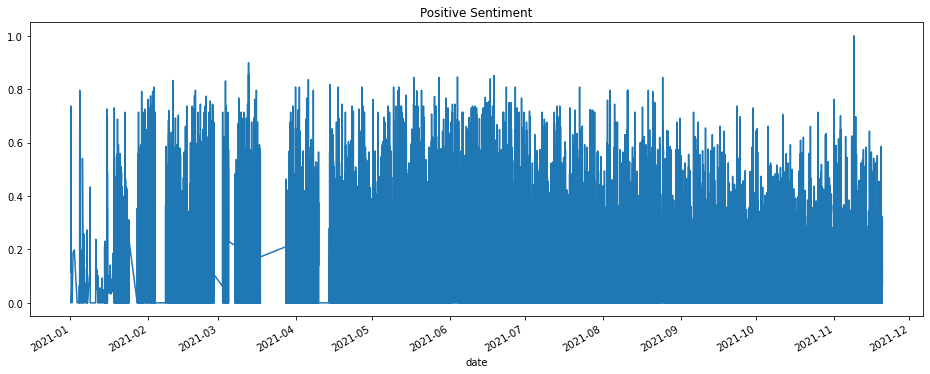

In [143]:
plt.figure(figsize=(16,6))
ts['Positive Sentiment'].plot()
plt.title('Positive Sentiment')
plt.show()

In [144]:
ts_daily = ts.resample('D').mean()

In [145]:
ts_daily.head()

Positive Sentiment
date                          
2021-01-01  0.165287          
2021-01-02  0.178001          
2021-01-03  0.000001          
2021-01-04  0.149126          
2021-01-05  0.073001

In [146]:
ts_daily.isna().sum()

Positive Sentiment    21
dtype: int64

In [156]:
plt.figure(figsize=(16,6))
ts_daily['Positive Sentiment'].plot()
plt.title('Positive Sentiment')
plt.show()

In [149]:
ts_q = ts.resample('M').mean()

In [150]:
ts_q

Positive Sentiment
date                          
2021-01-31  0.092434          
2021-02-28  0.097667          
2021-03-31  0.103852          
2021-04-30  0.111219          
2021-05-31  0.095332          
2021-06-30  0.105560          
2021-07-31  0.104050          
2021-08-31  0.102063          
2021-09-30  0.104362          
2021-10-31  0.103417          
2021-11-30  0.100010

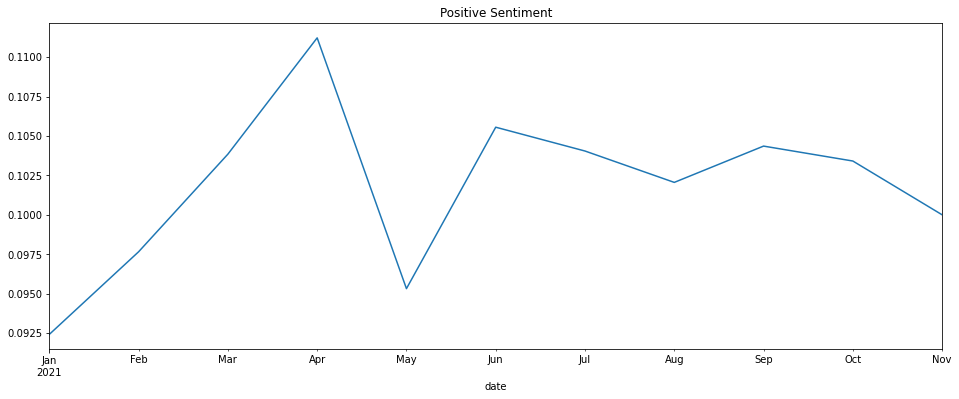

In [155]:
plt.figure(figsize=(16,6))
ts_q['Positive Sentiment'].plot()
plt.title('Positive Sentiment')
plt.show()